# MovieLens 100k Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens100k.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Concatenate, Dropout, LeakyReLU
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-100k/'  # if the files are local
# path = 'data/ml-1m/'  # ML-1m file
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [4]:
df.shape

(100000, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 943
Number of items: 1682
Min item rating: 1
Max item rating: 5
Mean item rating: 3.52986


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,releaseDate,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,24,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,147,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,233,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,75,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [8]:
def get_baseline(df, train_index, test_index):
    
    '''
    Calculate baseline features from an explicit ratings dataset. Receives a dataframe
    and returns train and test splits with added bias column and mean rating value.
    User and item biases are calculated as average difference from global mean rating.
    Baseline factors are only calculated from training observations, with users or
    items that do not appear in train receiving the global average as default.
    
    Args:
        df          : explicit ratings dataframe with columns userId, movieId and rating
        train_index : train index splits taken from KFold.splits()
        test_index  : test index splits taken from KFold.splits()
        
    Returns:
        train, test : train/test splits of df, with added bias column
        global_mean : average rating of all training observations
    '''
    
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    # compute global mean
    global_mean = train.rating.mean()

    # compute average item ratings
    item_averages = train.groupby(
        'movieId'
    ).agg(
        {'rating':'mean'}
    ).rename(
        {'rating': 'item_avg'}, axis=1
    ).reset_index()
    
    # add as column to train and test
    train = pd.merge(train, item_averages, how='left', on='movieId')
    test = pd.merge(test, item_averages, how='left', on='movieId').fillna(global_mean)
    
    # compute average user bias
    train['user_bias'] = train['rating'] - train['item_avg']
    
    user_biases = train.groupby(
        'userId'
    ).agg(
        {'user_bias':'mean'}
    ).rename(
        {'user_bias': 'user_avg'}, axis=1
    ).reset_index()
    
    # add as column to train and test
    train = pd.merge(train, user_biases, how='left', on='userId')
    test = pd.merge(test, user_biases, how='left', on='userId').fillna(0.0)
    
    # interaction bias
    train['bias'] = (train['user_avg'] + train['item_avg'] - global_mean)/2
    test['bias'] = (test['user_avg'] + test['item_avg'] - global_mean)/2
    
    return train, test, global_mean

---
# Genre model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [9]:
def compile_genre_model(n_items, n_users, mean_rating, n_genres, n_latent, n_hidden_1, n_hidden_2, dropout_1, dropout_2):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_latent)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_latent)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # concatenate user and item vectors
    conc = Concatenate()([item_vec, user_vec])
    # hidden layer
    hidden_1 = Dense(n_hidden_1)(conc)
    leaky = LeakyReLU(alpha=0.1)(hidden_1)
    drop_1 = Dropout(dropout_1)(leaky)
    
    out = Dense(1)(drop_1)
            
    rating = tf.math.add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # model 2
    hidden_2 = Dense(n_hidden_2, activation='relu')(item_vec)
    drop_2 = Dropout(dropout_2)(hidden_2)
    genre = Dense(n_genres, activation='sigmoid')(drop_2)  # there are 18 genres

    # Create model and compile it
    model2 = Model(item_in, genre)
    # freeze the embedding layer
    model2.layers[1].trainable = False
    model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy', 'AUC'])
    
    return model, model2

## Grid search

In [26]:
# hyper parameters
HP_N_FACTORS = [8, 32, 64, 128]
HP_N_HIDDEN_1 = [16, 32, 64]
HP_DROPOUT_1 = [.2, .25]
HP_N_HIDDEN_2 = [16, 32, 64]
# HP_DROPOUT_2 = [0, .2, .25]

In [29]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_1) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting rating model #{searches} with {N_FACTORS}: {N_HIDDEN_1} architecture')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(movies):
                
                # get baseline rating predictors for full dataset
                train, _, _ = get_baseline(df, df.index, df.index)

                # compile both models with search hparams
                model1, model2 = compile_genre_model(
                    n_items = df.movieId.nunique(),
                    n_users = df.userId.nunique(),
                    mean_rating = df.rating.mean(), 
                    n_genres=1,
                    n_latent=N_FACTORS, 
                    n_hidden_1=N_HIDDEN_1,
                    dropout_1=.2,
                    n_hidden_2=N_HIDDEN_2,
                    dropout_2=.25
                )

                # train rating model on all data
                ratings = model1.fit(
                    x=[train.userId.values, train.movieId.values, train.bias.values],
                    y=train.rating.values, 
                    batch_size=512,
                    epochs=10,
                    verbose=0,
                    validation_split=.2
                )
                
                # train genre model on 5 CV folds
                train = movies.iloc[train_index]
                test = movies.iloc[test_index]
                
                # initialise loss and epoch count
                total_loss = 0
                total_acc = 0
                count = 1
                min_epochs = 10
                
                # train model on current fold
                result = model2.fit(
                    train.movieId.values, train.Drama.values,
                    batch_size=64, 
                    epochs=5,
                    verbose=0,
                    validation_data=(test.movieId.values, test.Drama.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                fold_acc = np.max(result.history['val_accuracy'])
                total_acc += fold_acc
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
                count += 1
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            avg_acc = total_acc / 5
            print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
            print(f'_____________________________________CV avg val acc={avg_acc:.4f}')
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden_1':N_HIDDEN_1,
                                 'n_hidden_2':N_HIDDEN_2,
                                 'val_loss':avg_loss,
                                 'val_acc':avg_acc,
                                 'val_epochs':min_epochs,
                                 'train_hist':result.history['loss'],
                                 'val_hist':result.history['val_loss'],
                                 'train_acc':result.history['accuracy'],
                                 'val_acc':result.history['val_accuracy']})
            
            print()
#             break
#         break
#     break

# save results to data frame
grid_results = pd.DataFrame(data=grid_results, columns=grid_results[0].keys())

Fitting total of 36 models

Fitting rating model #1 with 8: 16 architecture
_____________________________________CV avg val loss=0.1624
_____________________________________CV avg val acc=0.1185

Fitting rating model #2 with 8: 16 architecture
_____________________________________CV avg val loss=0.1635
_____________________________________CV avg val acc=0.1219

Fitting rating model #3 with 8: 16 architecture
_____________________________________CV avg val loss=0.1602
_____________________________________CV avg val acc=0.1258

Fitting rating model #4 with 8: 32 architecture
_____________________________________CV avg val loss=0.1623
_____________________________________CV avg val acc=0.1272

Fitting rating model #5 with 8: 32 architecture
_____________________________________CV avg val loss=0.1607
_____________________________________CV avg val acc=0.1258

Fitting rating model #6 with 8: 32 architecture
_____________________________________CV avg val loss=0.1599
________________________

In [30]:
# get best 10 models
grid_results = grid_results.sort_values('val_loss')
grid_results.head(10)

,n_factors,n_hidden_1,n_hidden_2,dropout_1,val_loss,val_acc,val_epochs,train_hist,val_hist,train_acc
29,128,16,64,0.2,0.155979,"[0.66887414, 0.66225165, 0.6589404, 0.6589404,...",5,"[0.6859836932256338, 0.6628601255247556, 0.650...","[0.662180173081278, 0.6364097595214844, 0.6193...","[0.56647396, 0.6193229, 0.61601985, 0.6193229,..."
34,128,64,32,0.2,0.156021,"[0.66887414, 0.6655629, 0.6523179, 0.6589404, ...",5,"[0.6871430304402856, 0.6730869860810549, 0.658...","[0.6716432283256227, 0.6505199366847411, 0.630...","[0.5739059, 0.61023945, 0.6143683, 0.6151941, ..."
35,128,64,64,0.2,0.156139,"[0.6357616, 0.6589404, 0.63907284, 0.63907284,...",5,"[0.6813674964361404, 0.6619469944747591, 0.649...","[0.6603534865063547, 0.6387594831700356, 0.623...","[0.56234515, 0.60776216, 0.6168456, 0.6242775,..."
31,128,32,32,0.2,0.156195,"[0.6523179, 0.66225165, 0.66887414, 0.6721854,...",5,"[0.6824553089630102, 0.6654501018890362, 0.652...","[0.658987664229033, 0.6385881170531772, 0.6242...","[0.5796862, 0.60363334, 0.6300578, 0.6308836, ..."
20,64,16,64,0.2,0.156463,"[0.63245034, 0.6523179, 0.65562916, 0.66887414...",5,"[0.6843742501824283, 0.6682025735088856, 0.656...","[0.6676094954376979, 0.6464280734788503, 0.629...","[0.5755574, 0.6085879, 0.6143683, 0.6176714, 0..."
26,64,64,64,0.2,0.156511,"[0.6589404, 0.6721854, 0.6655629, 0.6589404, 0...",5,"[0.6833529465952557, 0.6665088489073353, 0.655...","[0.6622379078770315, 0.642779600936056, 0.6280...","[0.59042114, 0.6168456, 0.6110652, 0.6151941, ..."
28,128,16,32,0.2,0.156589,"[0.59933776, 0.6258278, 0.6258278, 0.62913907,...",5,"[0.6811715462894896, 0.6630456267950655, 0.651...","[0.6638972782930791, 0.6405052144006388, 0.624...","[0.5962015, 0.60611063, 0.6085879, 0.6094137, ..."
32,128,32,64,0.2,0.156847,"[0.60264903, 0.6258278, 0.62913907, 0.6357616,...",5,"[0.6897337622725206, 0.6689959122167944, 0.653...","[0.6703045068197693, 0.6467915548394058, 0.631...","[0.5326177, 0.6110652, 0.625929, 0.6242775, 0...."
17,32,64,64,0.2,0.157369,"[0.6423841, 0.6423841, 0.6490066, 0.6456954, 0...",5,"[0.6864948897298755, 0.6730155116462393, 0.660...","[0.6716150262497909, 0.6515873749524552, 0.637...","[0.5590421, 0.58794385, 0.5962015, 0.59454995,..."
14,32,32,64,0.2,0.157538,"[0.63245034, 0.63245034, 0.63907284, 0.6324503...",5,"[0.6867553540047883, 0.6702993503786334, 0.658...","[0.6701157341729727, 0.6515914020159387, 0.636...","[0.5829893, 0.6143683, 0.61023945, 0.61271673,..."


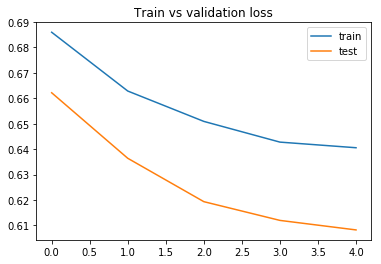

In [31]:
# plot training curve of best model
plt.plot(grid_results.train_hist.values[0], label='train')
plt.plot(grid_results.val_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

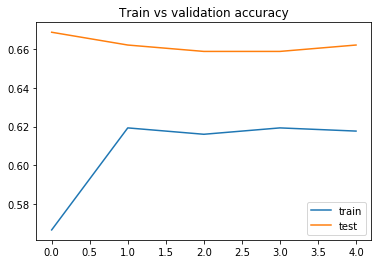

In [32]:
# train vs test accuracy
plt.plot(grid_results.train_acc.values[0], label='train')
plt.plot(grid_results.val_acc.values[0], label='test')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [34]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden_1', 'n_hidden_2']]
best_rating_hparams

n_factors     128
n_hidden_1     16
n_hidden_2     64
Name: 29, dtype: object

## Classification report

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [37]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items = df.movieId.nunique(),
    n_users = df.userId.nunique(),
    mean_rating = df.rating.mean(), 
    n_genres=1,
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_1=.25,
    dropout_2=.2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=64, 
    epochs=5,
    validation_split=.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 2s 24us/sample - loss: 0.8982 - val_loss: 0.8624
Epoch 2/10
80000/80000 [==============================] - 2s 20us/sample - loss: 0.8501 - val_loss: 0.8541
Epoch 3/10
80000/80000 [==============================] - 2s 19us/sample - loss: 0.8333 - val_loss: 0.8511
Epoch 4/10
80000/80000 [==============================] - 2s 20us/sample - loss: 0.8202 - val_loss: 0.8459
Epoch 5/10
80000/80000 [==============================] - 2s 19us/sample - loss: 0.8082 - val_loss: 0.8452
Epoch 6/10
80000/80000 [==============================] - 2s 19us/sample - loss: 0.7962 - val_loss: 0.8414
Epoch 7/10
80000/80000 [==============================] - 2s 20us/sample - loss: 0.7813 - val_loss: 0.8375
Epoch 8/10
80000/80000 [==============================] - 2s 19us/sample - loss: 0.7694 - val_loss: 0.8385
Epoch 9/10
80000/80000 [==============================] - 2s 19us/sample - loss: 0.7619 - val_

### Evaluate on test set

In [38]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        96
           1       0.56      0.59      0.57        73

    accuracy                           0.62       169
   macro avg       0.62      0.62      0.62       169
weighted avg       0.62      0.62      0.62       169



In [40]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,62,34
1,30,43


---
# Appendix A: Ratings model

## Define architecture

In [7]:
def compile_model(n_users, n_items, mean_rating, n_factors=25, n_hidden=64, leaky_alpha=.1, dropout=.2):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_factors)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_factors)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # if there is a hidden layer
    if n_hidden:
        # concatenate user and item vectors
        conc = Concatenate()([item_vec, user_vec])
        # hidden layer
        hidden = Dense(n_hidden)(conc)
        leaky = LeakyReLU(alpha=leaky_alpha)(hidden)
        drop = Dropout(dropout)(leaky)
        
        out = Dense(1)(drop)
        
    # if there are no hidden layers
    else:
        out = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
    
    rating = tf.math.add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

## Grid search
### Best CV score: 0.920123 (20 : 40 : 0.2)
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars
```python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

In [8]:
# hyper parameters
HP_N_FACTORS = [8, 32, 64, 128]
HP_N_HIDDEN = [0, 16, 32, 64]
HP_DROPOUT = [0, .2, .25]

In [9]:
# dataframe to store results of grid search
grid_results = []
best_loss = 1
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN) * len(HP_DROPOUT)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN in HP_N_HIDDEN:
        for DROPOUT in HP_DROPOUT:
            
            print(f'Fitting model #{searches} with {N_FACTORS}: {N_HIDDEN} architecture, {DROPOUT} dropout rate')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss, count = 0, 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(df):
                train, test, global_mean = get_baseline(df, train_index, test_index)
                
                # compile model with chosen h-params
                model = compile_model(
                    n_users = df.userId.nunique(),
                    n_items = df.movieId.nunique(),
                    mean_rating = global_mean,
                    n_factors = N_FACTORS,
                    n_hidden = N_HIDDEN,
                    dropout = DROPOUT
                )
                
                # train model on CV fold
                result = model.fit(x=[train.userId.values, train.movieId.values, train.bias.values],
                                   y=train.rating.values, 
                                   batch_size=512,
                                   epochs=10,
                                   verbose=0,
                                   validation_data=([test.userId.values, test.movieId.values, test.bias.values], test.rating.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
#                 print(f'CV split #{count}: RMSE={fold_loss:.4f}')
                count += 1
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            best_loss = min(avg_loss, best_loss)
            print(f'_____________________________________CV avg RMSE={avg_loss:.4f}')
            
#             plt.plot(result.history['loss'], label='train')
#             plt.plot(result.history['val_loss'], label='val')
#             plt.axhline(y=best_loss, color='r', lw=1, ls='-')
#             plt.legend()
#             plt.show()
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden':N_HIDDEN,
                                 'dropout':DROPOUT,
                                 'val_rmse':avg_loss,
                                 'val_epochs':min_epochs,
                                 'train_hist':result.history['loss'],
                                 'val_hist':result.history['val_loss']})
            print()
            break
        break
#     break

# save results to data frame
grid_results = pd.DataFrame(data=grid_results, columns=grid_results[0].keys())

Fitting total of 48 models

Fitting model #1 with 8: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9457

Fitting model #2 with 32: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9344

Fitting model #3 with 64: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9312

Fitting model #4 with 128: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9294



In [10]:
# get best 10 models
grid_results = grid_results.sort_values('val_rmse')
grid_results.head(10)

,n_factors,n_hidden,dropout,val_rmse,val_epochs,train_hist,val_hist
3,128,0,0,0.929420,6,"[0.9448764749526978, 0.9171774558067322, 0.841...","[0.967871939086914, 0.9573996433258056, 0.9177..."
2,64,0,0,0.931192,7,"[0.9447980142593384, 0.9308741952896118, 0.890...","[0.9683909816741944, 0.9633234424591064, 0.938..."
1,32,0,0,0.934400,8,"[0.9448338025093078, 0.937631623840332, 0.9148...","[0.9684047742843628, 0.9652086585998535, 0.948..."
0,8,0,0,0.945660,10,"[0.9448830952644348, 0.9432240547180176, 0.938...","[0.9686725238800049, 0.9682414264678955, 0.965..."


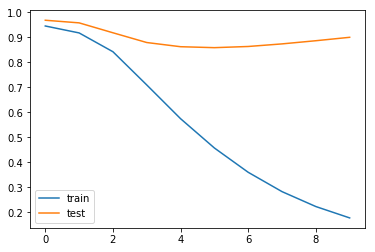

In [11]:
# plot training curve of best model
plt.plot(grid_results.iloc[0,-2], label='train')
plt.plot(grid_results.iloc[0,-1], label='test')
plt.legend()
plt.show()

In [12]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden', 'dropout']]
best_rating_hparams

n_factors    128
n_hidden       0
dropout        0
Name: 3, dtype: object

---
# Appendix B: multi-label genre model

In [15]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items = df.movieId.nunique(),
    n_users = df.userId.nunique(),
    mean_rating = df.rating.mean(), 
    n_genres=18,
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden,
    n_hidden_2=64,
    dropout_1=best_rating_hparams.dropout,
    dropout_2=.2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=.2
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 1s 18us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 2/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 3/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 4/10
80000/80000 [==============================] - 1s 13us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 5/10
80000/80000 [==============================] - 1s 13us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 6/10
80000/80000 [==============================] - 1s 14us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 7/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 8/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 9/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_

In [16]:
# train genre model
genres = model2.fit(
#     movies.movieId.values, movies.Drama.values,  # drama only
    movies.movieId.values, movies.iloc[:,-18:].values,  # multi label
    batch_size=64, 
    epochs=5,
    validation_split=.2)

Train on 1345 samples, validate on 337 samples
Epoch 1/5
1345/1345 [==============================] - 0s 367us/sample - loss: 0.6794 - accuracy: 0.7493 - val_loss: 0.6625 - val_accuracy: 0.9054
Epoch 2/5
1345/1345 [==============================] - 0s 38us/sample - loss: 0.6466 - accuracy: 0.8887 - val_loss: 0.6172 - val_accuracy: 0.9228
Epoch 3/5
1345/1345 [==============================] - 0s 37us/sample - loss: 0.5925 - accuracy: 0.8994 - val_loss: 0.5452 - val_accuracy: 0.9232
Epoch 4/5
1345/1345 [==============================] - 0s 41us/sample - loss: 0.5168 - accuracy: 0.8998 - val_loss: 0.4540 - val_accuracy: 0.9232
Epoch 5/5
1345/1345 [==============================] - 0s 39us/sample - loss: 0.4349 - accuracy: 0.8998 - val_loss: 0.3683 - val_accuracy: 0.9232


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [18]:
y_true = movies.iloc[:,-18:]
y_score = pd.DataFrame(model2.predict(movies.movieId.values), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [19]:
drama_true = y_true.Drama
drama_pred = y_pred.Drama

In [20]:
print(classification_report(drama_true, drama_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       957
           1       0.00      0.00      0.00       725

    accuracy                           0.57      1682
   macro avg       0.28      0.50      0.36      1682
weighted avg       0.32      0.57      0.41      1682



C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
pd.DataFrame(confusion_matrix(drama_true, drama_pred))

,0,1
0,957,0
1,725,0


In [22]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       251
   Adventure       0.00      0.00      0.00       135
   Animation       0.00      0.00      0.00        42
  Children's       0.00      0.00      0.00       122
      Comedy       0.00      0.00      0.00       505
       Crime       0.00      0.00      0.00       109
 Documentary       0.00      0.00      0.00        50
       Drama       0.00      0.00      0.00       725
     Fantasy       0.00      0.00      0.00        22
   Film-Noir       0.00      0.00      0.00        24
      Horror       0.00      0.00      0.00        92
     Musical       0.00      0.00      0.00        56
     Mystery       0.00      0.00      0.00        61
     Romance       0.00      0.00      0.00       247
      Sci-Fi       0.00      0.00      0.00       101
    Thriller       0.00      0.00      0.00       251
         War       0.00      0.00      0.00        71
     Western       0.00    

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being